In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install numpy
!pip install matplotlib
!pip install ipympl 

%matplotlib widget

In [1]:
import gymcad
import torch
import model

In [ ]:
#It was saved as an example for monitoring process

import clr # the pythonnet module.
clr.AddReference(r'D:\openhardwaremonitor-v0.9.6\OpenHardwareMonitor\OpenHardwareMonitorLib') 
# e.g. clr.AddReference(r'OpenHardwareMonitor/OpenHardwareMonitorLib'), without .dll

from OpenHardwareMonitor.Hardware import Computer

c = Computer()
c.CPUEnabled = True # get the Info about CPU
c.GPUEnabled = True # get the Info about GPU
c.Open()
while True:
    for a in range(0, len(c.Hardware[0].Sensors)):
        print(c.Hardware[0].Sensors[a].Identifier)
        if "/temperature" in str(c.Hardware[0].Sensors[a].Identifier):
            print(c.Hardware[0].Sensors[a].get_Value())
            c.Hardware[0].Update()

In [2]:
def mini_batch_train(env, agent, max_episodes, max_step, batch_size, tar_update_fr, update_fr, eps_step):
  """The training loop of the DQNAgent. Steps the environment,
  saves observations and calls model training.

  Inputs:
    agent         - model, DQNAgent class;
    max_episodes  - int, number of episodes;
    max_step      - int, max number of step in one episedes;
    batch_size    - int, size of batch;
    tar_update_fr - int, target model update rate (number of steps);
    update_fr     - int, model update rate (number of steps);
    eps_step      - int, index of last step (if it is necessary to continue learning).

  Return:
    episodes_rewards - list, size (max_episodes, 1), collection of rewards of each episodes;

  """
  
  start_traing = False # need to turn on the train mode for model

  global_step = eps_step*max_step # need to return to the rigth point if learning process is continued
  episode_rewards = []

  agent.target_model.eval() # firstly need to collect buffer
  agent.model.eval()

  for episode in range(max_episodes):
    state = env.reset()
    if start_traing:
      agent.model.train()
    
    negative_reward_counter = 0
    local_step = 1
    episode_reward = 0

    positive_reward_counter = 0
    random_action_counter = 0
    
    while True:
      global_step += 1
      epsi = model.epsilon(global_step)
      action, eps_res = agent.get_action(state, epsi)
      
      next_state, reward, done, _ = env.step(action)

      agent.reply_buffer.push(state, action, reward, next_state, done)
      episode_reward += reward

      if (len(agent.reply_buffer) > 1000) and (global_step % update_fr == 0): # start of learning if buffer is collected enough
        if start_traing == False: # for the start learning procees it is necessary to turn on the train mode of model
            agent.model.train()
            start_traing = True
            print("Start_learning")
        agent.update(batch_size)

      # from the certain number of step to start counting number of steps with negative rewards
      # now it is not used, but befor it was used to stop episodes
      negative_reward_counter = negative_reward_counter + 1 if local_step > max_step-25 and reward < 0 else 0

      if reward > 0:
        positive_reward_counter += 1

      # count of random actions for statistic
      if eps_res:
        random_action_counter += 1

      # according to the rate update target model
      if global_step % tar_update_fr == 0:
         agent.update_target()
      
      # end of episode
      if done or local_step >= max_step: 
        episode_rewards.append(episode_reward)
        print("Episode " + str(episode+eps_step) + ": " + str(round(episode_reward, 1)) + " Done: " + str(done) + " step: " + str(local_step) + " number_pos: " + str(positive_reward_counter) + " rendom_ration, " + str(round(100*random_action_counter/local_step)))
        break

      state = next_state
      local_step += 1

    state = env.reset()
    
    negative_reward_counter = 0
    local_step = 1
    agent.model.eval()

    # save checkpoint of agent model
    if episode%25 == 0:
      checkpoint = {
            'epoch': global_step,
            'state_dict': agent.model.state_dict(),
            'optimizer': agent.optimizer.state_dict()
        }
      model.save_ckp(checkpoint, False, 'box_cad_tests', 'box_cad_tests', str(episode+eps_step))

  return episode_rewards

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gymcad.BoxCAD(device)
agent1 = model.DQNAgent(env, device)

d:\Research\Research\model.py:87: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
# load saved learning checkpoint
ckp_path = "box_cad_tests/6976checkpoint.pt"
agent1.model, agent1.optimizer, start_epoch = model.load_ckp(ckp_path, agent1.model, agent1.optimizer)

In [4]:
MAX_EPISODE = 1
MAX_STEP = 100
BATCH_SIZE = 64

episode_rewards1 = mini_batch_train(env, agent1, MAX_EPISODE, MAX_STEP, BATCH_SIZE, 25, 5, eps_step=1)

Episode 1: -46.7 Done: True step: 57 number_pos: 6 rendom_ration, 100


In [5]:
env.step(0)

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [ ]:
print(env.previous_boxes)
print(env.current_box)
print(env.first_step_done)

In [7]:
%matplotlib widget

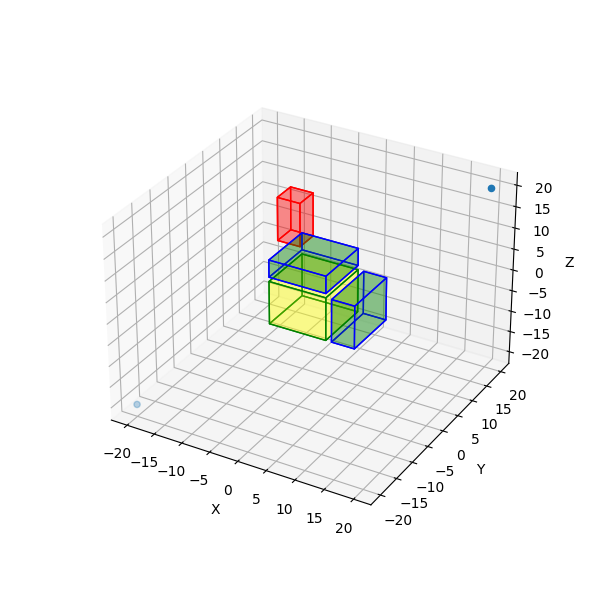

In [8]:
env.render(type_rendiring="3D")

In [ ]:
# check trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gymcad.BoxCAD(device)

all_reward = 0

for i in range(500):

  action = env.action_sample()
  new_state, reward, done, _ = env.step(action)
  all_reward += reward
  print("Iteration: ", action, " Reward: ", reward, "/", all_reward, " Done " , done)
   
  if done:
    break

In [ ]:
%matplotlib widget

In [ ]:
# import matplotlib
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.add_subplot(projection='3d')
x = [0,1,1,0]
y = [0,0,1,1]
z = [0,1,0,1]
verts = [[xx,yy,zz] for xx,yy,zz in zip(x,y,z)]     # NEW
ax.add_collection3d(Poly3DCollection([verts]))
plt.show()